In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from corner import corner
from tqdm.notebook import tqdm
from scipy.special import erf
import h5py
import sys
sys.path.append('./../../code/')
from support import *
sys.path.append('./../../review/')
from makeCorner import *
import json

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

## BBH forecast

In [2]:
# Load data
processed_samps = np.load('../results_11-29/processed_emcee_samples_bbh_fixedRedshiftEvolution_nEffCut_r00.npy','r')
params = ['R0','mMin','mMax','lmbda','m0','sigM','fp','bq','muEff','sigEff']

# For comparison, load rate density spectrum from gwpopulation
gwpopFile = "/home/thomas.callister/CBC/o3b-population-data/analyses/PowerLawPeak/o1o2o3_mass_c_iid_mag_iid_tilt_powerlaw_redshift_mass_data.h5"
f = h5py.File(gwpopFile,'r')

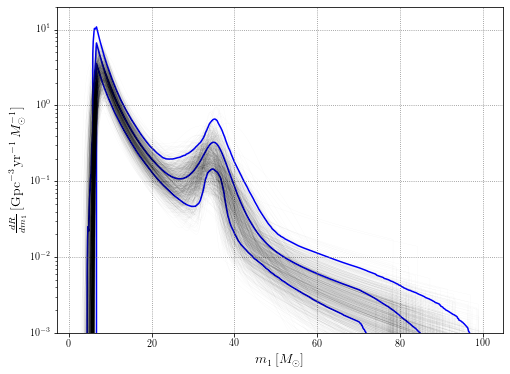

In [8]:
# Helper functions defining PL+Peak mass distribution
def Calculate_Gaussian(x, mu, sigma2, low, high):
    norm = np.sqrt(sigma2*np.pi/2)*(-erf((low-mu)/np.sqrt(2*sigma2)) + erf((high-mu)/np.sqrt(2*sigma2)))
    y = (1.0/norm)*np.exp((-1.0*(x-mu)**2)/(2.*sigma2))
    y[np.where(x<low)] = 0.
    return y

def plPeakDistribution(m1,lmbda,mu_peak,sig_peak,mMin,mMax,frac_peak):
    p_m1_pl = (1.+lmbda)*m1**lmbda/(mMax**(1.+lmbda) - mMin**(1.+lmbda))
    p_m1_peak = Calculate_Gaussian(m1,mu_peak,sig_peak**2,mMin,mMax)
    return frac_peak*p_m1_peak + (1.-frac_peak)*p_m1_pl

# Set up figure
fig,ax = plt.subplots(figsize=(8,6))

# Loop across gwpopulation results, plotting posteriors on dR/dm1
m1_grid = np.linspace(2,100,1000)
for i in range(1000):
    y = f['lines']['mass_1'][i,:]
    ax.plot(np.linspace(2,100,1000),y,color='black',alpha=0.1,lw=0.1)

# Now compute mass posteriors as inferred by our stochastic-oriented analysis
p_m1s = np.zeros((processed_samps.shape[0],m1_grid.size))
for i,samp in enumerate(processed_samps):
    
    R0 = samp[0]
    mMin = samp[1]
    mMax = samp[2]
    lmbda = samp[3]
    mu_peak = samp[4]
    sig_peak = samp[5]
    frac_peak = samp[6]
    
    p_m1 = R0*plPeakDistribution(m1_grid,lmbda,mu_peak,sig_peak,mMin,mMax,frac_peak)
    p_m1[m1_grid<mMin] = 0
    p_m1[m1_grid>mMax] = 0
    p_m1s[i] = p_m1
    
# Plot quantiles
ax.plot(m1_grid,np.mean(p_m1s,axis=0),color='blue',zorder=-1)
ax.plot(m1_grid,np.quantile(p_m1s,0.05,axis=0),color='blue',zorder=-1)
ax.plot(m1_grid,np.quantile(p_m1s,0.95,axis=0),color='blue',zorder=-1)

ax.set_yscale('log')
ax.set_ylim(1e-3,20)
ax.set_xlabel(r'$m_1\,[M_\odot]$',fontsize=14)
ax.set_ylabel(r'$\frac{dR}{dm_1}\,[\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,M_\odot^{-1}]$',fontsize=14)
ax.grid(True,which='major',color='grey',ls=':')

plt.savefig('gwpop_comparison.png',dpi=150)
plt.show()

## R(z) inference, CBC only

In [9]:
processed_samps = np.load('../results_11-29/processed_emcee_samples_noStochastic_r00r01.npy')
params = ['muEff','sigEff','R0','mMin','mMax','lmbda','m0','sigM','fp','bq','alpha','beta','zp']

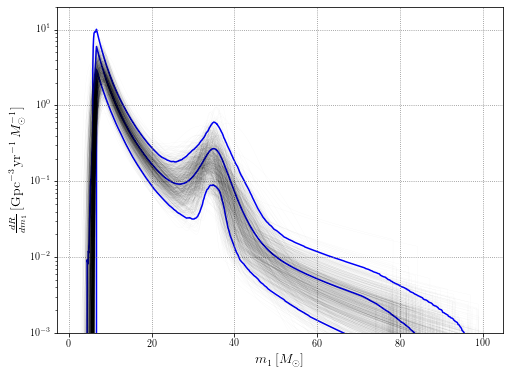

In [10]:
# Set up figure
fig,ax = plt.subplots(figsize=(8,6))

# Loop across gwpopulation results, plotting posteriors on dR/dm1
m1_grid = np.linspace(2,100,1000)
for i in range(1000):
    y = f['lines']['mass_1'][i,:]
    ax.plot(np.linspace(2,100,1000),y,color='black',alpha=0.1,lw=0.1)

# Now compute mass posteriors as inferred by our stochastic-oriented analysis
p_m1s = np.zeros((processed_samps.shape[0],m1_grid.size))
for i,samp in enumerate(processed_samps):
    
    R0 = samp[2]
    mMin = samp[3]
    mMax = samp[4]
    lmbda = samp[5]
    mu_peak = samp[6]
    sig_peak = samp[7]
    frac_peak = samp[8]
    
    p_m1 = R0*plPeakDistribution(m1_grid,lmbda,mu_peak,sig_peak,mMin,mMax,frac_peak)
    p_m1[m1_grid<mMin] = 0
    p_m1[m1_grid>mMax] = 0
    p_m1s[i] = p_m1
    
# Plot quantiles
ax.plot(m1_grid,np.mean(p_m1s,axis=0),color='blue',zorder=-1)
ax.plot(m1_grid,np.quantile(p_m1s,0.05,axis=0),color='blue',zorder=-1)
ax.plot(m1_grid,np.quantile(p_m1s,0.95,axis=0),color='blue',zorder=-1)

ax.set_yscale('log')
ax.set_ylim(1e-3,20)
ax.set_xlabel(r'$m_1\,[M_\odot]$',fontsize=14)
ax.set_ylabel(r'$\frac{dR}{dm_1}\,[\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,M_\odot^{-1}]$',fontsize=14)
ax.grid(True,which='major',color='grey',ls=':')

plt.savefig('rz_noStochastic_gwpop_comparison.png',dpi=150)
plt.show()

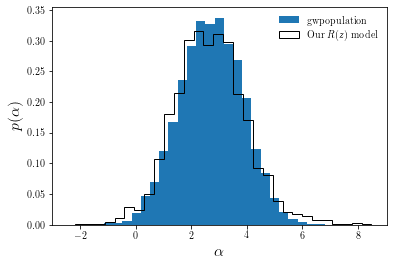

In [11]:
gwpop_file = "/home/thomas.callister/CBC/o3b-population-data/analyses/PowerLawPeak/o1o2o3_mass_c_iid_mag_iid_tilt_powerlaw_redshift_result.json"
with open(gwpop_file,'r') as jf:
    gwpop_results = json.load(jf)

fig,ax = plt.subplots()
ax.hist(np.array(gwpop_results['posterior']['content']['lamb']),density=True,bins=30,
        label="gwpopulation")
ax.hist(processed_samps[:,-3],density=True,bins=30,
        histtype='step',color='black',label="Our $R(z)$ model")
ax.legend(loc='upper right',frameon=False)
ax.set_xlabel(r'$\alpha$',fontsize=16)
ax.set_ylabel(r'$p(\alpha)$',fontsize=16)
plt.savefig('rz_noStochastic_alphaComparison.png',dpi=150)
plt.show()

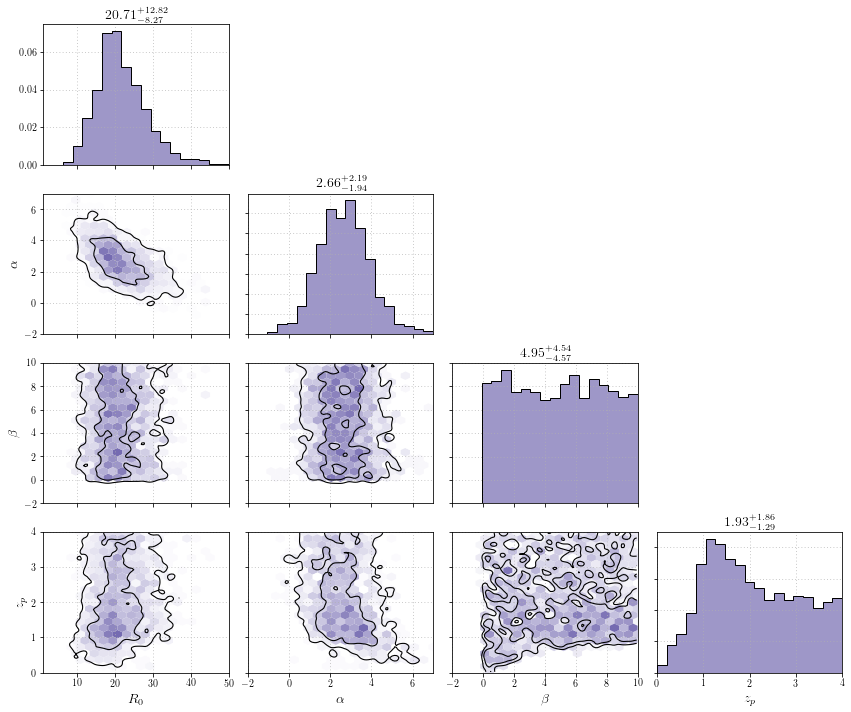

In [12]:
to_plot = {
    'R0':{'data':processed_samps[:,2],'plot_bounds':(1,50),'label':r"$R_0$"},
    'alpha':{'data':processed_samps[:,-3],'plot_bounds':(-2,7),'label':r"$\alpha$"},
    'beta':{'data':processed_samps[:,-2],'plot_bounds':(-2,10),'label':r"$\beta$"},
    'zp':{'data':processed_samps[:,-1],'plot_bounds':(0,4),'label':r"$z_p$"}
}

fig = plt.figure(figsize=(12,10))
plot_corner(fig,to_plot,"#756bb1")
plt.savefig('rz_noStochastic_corner.png',dpi=150)
plt.show()

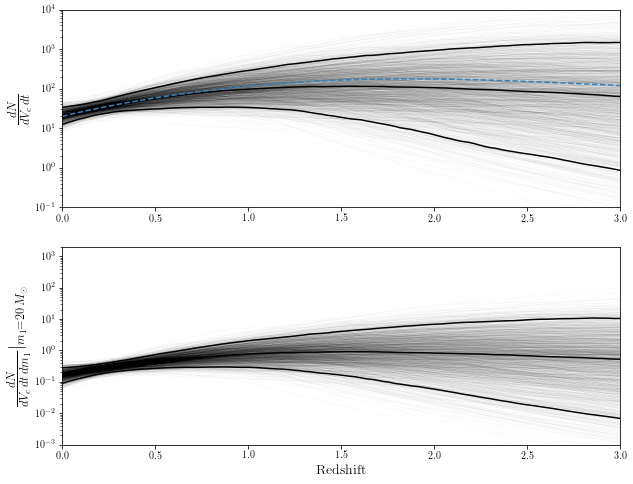

In [13]:
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

# Grid of redshifts
z_grid = np.linspace(0,3,100)

# Track two different rate densities --
# The rate density dR/dm1(z) evaluated *at* 20Msun, and the overall rate density
# R(z), integrated over masses
r_zs_m1 = np.zeros((processed_samps.shape[0],z_grid.size))
r_zs = np.zeros((processed_samps.shape[0],z_grid.size))

# Loop across samples
for i,samp in enumerate(processed_samps):
    
    R0 = samp[2]
    mMin = samp[3]
    mMax = samp[4]
    lmbda = samp[5]
    mu_peak = samp[6]
    sig_peak = samp[7]
    frac_peak = samp[8]
    alpha = samp[10]
    beta = samp[11]
    zp = samp[12]
    
    # Evaluate mass distribution at 20 Msun
    p_m1 = plPeakDistribution(np.array([20.]),lmbda,mu_peak,sig_peak,mMin,mMax,frac_peak)
    
    # Construct R(z) and normalize to local merger rate
    r_z = (1.+z_grid)**alpha/(1.+((1.+z_grid)/(1.+zp))**(alpha+beta))
    r_z /= r_z[0]
    r_z *= R0
    
    # Store
    r_zs[i,:] = r_z
    r_zs_m1[i,:] = r_z*p_m1
    
    ax1.plot(z_grid,r_z,color='black',lw=0.1,alpha=0.1)
    ax2.plot(z_grid,r_z*p_m1,color='black',lw=0.1,alpha=0.1)

ax1.plot(z_grid,np.quantile(r_zs,0.05,axis=0),color='black') 
ax1.plot(z_grid,np.quantile(r_zs,0.95,axis=0),color='black') 
ax1.plot(z_grid,np.median(r_zs,axis=0),color='black')

ax2.plot(z_grid,np.quantile(r_zs_m1,0.05,axis=0),color='black') 
ax2.plot(z_grid,np.quantile(r_zs_m1,0.95,axis=0),color='black') 
ax2.plot(z_grid,np.median(r_zs_m1,axis=0),color='black')

MD_SFR = np.power(1.+z_grid,2.7)/(1.+np.power((1.+z_grid)/2.9,5.6))
MD_SFR *= 20/MD_SFR[0]
ax1.plot(z_grid,MD_SFR,color='#3182bd',ls='--')

ax1.set_yscale('log')
ax1.set_xlim(0,3)
ax1.set_ylim(1e-1,1e4)
ax1.set_ylabel(r'$\frac{dN}{dV_c\,dt}$',fontsize=18)

ax2.set_yscale('log')
ax2.set_xlim(0,3)
ax2.set_ylim(1e-3,2e3)
ax2.set_xlabel('Redshift',fontsize=14)
ax2.set_ylabel(r'$\frac{dN}{dV_c\,dt\,dm_1}|_{m_1=20\,M_\odot}$',fontsize=18)

plt.savefig('rz_noStochastic_rateEvolution.png',dpi=150)
plt.show()

In [15]:
print(np.quantile(r_zs[:,-1],0.5))
print(np.quantile(r_zs[:,-1],0.95))

63.96247364801786
1480.0345137772238


## R(z) inference, CBC+Stochastic

In [17]:
processed_samps = np.load('../results_11-29/processed_emcee_samples_together_r00r01.npy')
params = ['muEff','sigEff','R0','mMin','mMax','lmbda','m0','sigM','fp','bq','alpha','beta','zp']

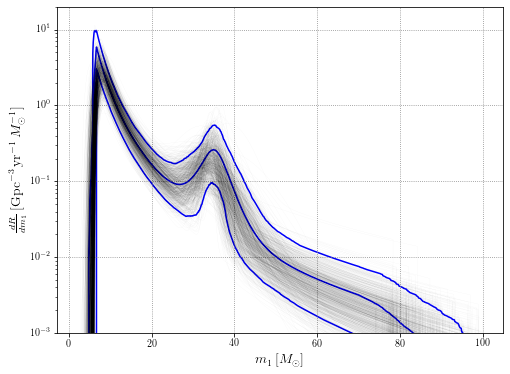

In [18]:
# Set up figure
fig,ax = plt.subplots(figsize=(8,6))

# Loop across gwpopulation results, plotting posteriors on dR/dm1
m1_grid = np.linspace(2,100,1000)
for i in range(1000):
    y = f['lines']['mass_1'][i,:]
    ax.plot(np.linspace(2,100,1000),y,color='black',alpha=0.1,lw=0.1)

# Now compute mass posteriors as inferred by our stochastic-oriented analysis
p_m1s = np.zeros((processed_samps.shape[0],m1_grid.size))
for i,samp in enumerate(processed_samps):
    
    R0 = samp[2]
    mMin = samp[3]
    mMax = samp[4]
    lmbda = samp[5]
    mu_peak = samp[6]
    sig_peak = samp[7]
    frac_peak = samp[8]
    
    p_m1 = R0*plPeakDistribution(m1_grid,lmbda,mu_peak,sig_peak,mMin,mMax,frac_peak)
    p_m1[m1_grid<mMin] = 0
    p_m1[m1_grid>mMax] = 0
    p_m1s[i] = p_m1
    
# Plot quantiles
ax.plot(m1_grid,np.mean(p_m1s,axis=0),color='blue',zorder=-1)
ax.plot(m1_grid,np.quantile(p_m1s,0.05,axis=0),color='blue',zorder=-1)
ax.plot(m1_grid,np.quantile(p_m1s,0.95,axis=0),color='blue',zorder=-1)

ax.set_yscale('log')
ax.set_ylim(1e-3,20)
ax.set_xlabel(r'$m_1\,[M_\odot]$',fontsize=14)
ax.set_ylabel(r'$\frac{dR}{dm_1}\,[\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,M_\odot^{-1}]$',fontsize=14)
ax.grid(True,which='major',color='grey',ls=':')

plt.savefig('rz_together_gwpop_comparison.png',dpi=150)
plt.show()

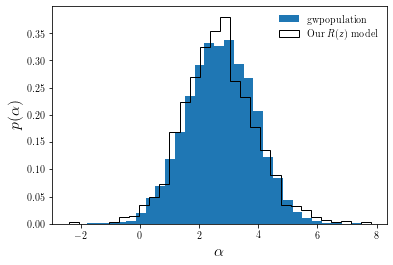

In [19]:
gwpop_file = "/home/thomas.callister/CBC/o3b-population-data/analyses/PowerLawPeak/o1o2o3_mass_c_iid_mag_iid_tilt_powerlaw_redshift_result.json"
with open(gwpop_file,'r') as jf:
    gwpop_results = json.load(jf)

fig,ax = plt.subplots()
ax.hist(np.array(gwpop_results['posterior']['content']['lamb']),density=True,bins=30,
        label="gwpopulation")
ax.hist(processed_samps[:,-3],density=True,bins=30,
        histtype='step',color='black',label="Our $R(z)$ model")
ax.legend(loc='upper right',frameon=False)
ax.set_xlabel(r'$\alpha$',fontsize=16)
ax.set_ylabel(r'$p(\alpha)$',fontsize=16)
plt.savefig('rz_together_alphaComparison.png',dpi=150)
plt.show()

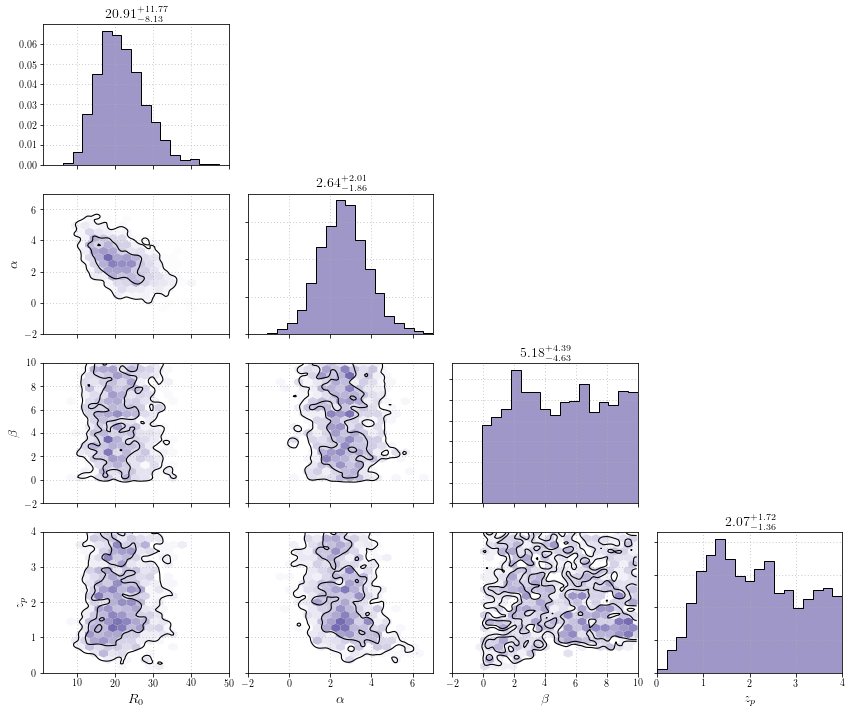

In [20]:
to_plot = {
    'R0':{'data':processed_samps[:,2],'plot_bounds':(1,50),'label':r"$R_0$"},
    'alpha':{'data':processed_samps[:,-3],'plot_bounds':(-2,7),'label':r"$\alpha$"},
    'beta':{'data':processed_samps[:,-2],'plot_bounds':(-2,10),'label':r"$\beta$"},
    'zp':{'data':processed_samps[:,-1],'plot_bounds':(0,4),'label':r"$z_p$"}
}

fig = plt.figure(figsize=(12,10))
plot_corner(fig,to_plot,"#756bb1")
plt.savefig('rz_together_corner.png',dpi=150)
plt.show()

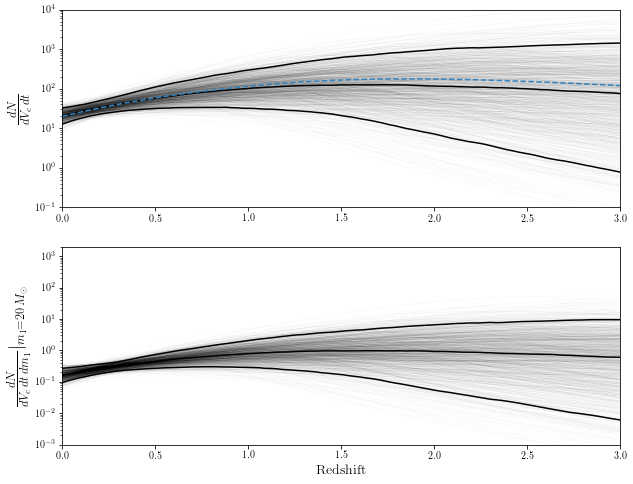

In [21]:
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

# Grid of redshifts
z_grid = np.linspace(0,3,100)

# Track two different rate densities --
# The rate density dR/dm1(z) evaluated *at* 20Msun, and the overall rate density
# R(z), integrated over masses
r_zs_m1 = np.zeros((processed_samps.shape[0],z_grid.size))
r_zs = np.zeros((processed_samps.shape[0],z_grid.size))

# Loop across samples
for i,samp in enumerate(processed_samps):
    
    R0 = samp[2]
    mMin = samp[3]
    mMax = samp[4]
    lmbda = samp[5]
    mu_peak = samp[6]
    sig_peak = samp[7]
    frac_peak = samp[8]
    alpha = samp[10]
    beta = samp[11]
    zp = samp[12]
    
    # Evaluate mass distribution at 20 Msun
    p_m1 = plPeakDistribution(np.array([20.]),lmbda,mu_peak,sig_peak,mMin,mMax,frac_peak)
    
    # Construct R(z) and normalize to local merger rate
    r_z = (1.+z_grid)**alpha/(1.+((1.+z_grid)/(1.+zp))**(alpha+beta))
    r_z /= r_z[0]
    r_z *= R0
    
    # Store
    r_zs[i,:] = r_z
    r_zs_m1[i,:] = r_z*p_m1
    
    ax1.plot(z_grid,r_z,color='black',lw=0.1,alpha=0.1)
    ax2.plot(z_grid,r_z*p_m1,color='black',lw=0.1,alpha=0.1)

ax1.plot(z_grid,np.quantile(r_zs,0.05,axis=0),color='black') 
ax1.plot(z_grid,np.quantile(r_zs,0.95,axis=0),color='black') 
ax1.plot(z_grid,np.median(r_zs,axis=0),color='black')

ax2.plot(z_grid,np.quantile(r_zs_m1,0.05,axis=0),color='black') 
ax2.plot(z_grid,np.quantile(r_zs_m1,0.95,axis=0),color='black') 
ax2.plot(z_grid,np.median(r_zs_m1,axis=0),color='black')

MD_SFR = np.power(1.+z_grid,2.7)/(1.+np.power((1.+z_grid)/2.9,5.6))
MD_SFR *= 20/MD_SFR[0]
ax1.plot(z_grid,MD_SFR,color='#3182bd',ls='--')

ax1.set_yscale('log')
ax1.set_xlim(0,3)
ax1.set_ylim(1e-1,1e4)
ax1.set_ylabel(r'$\frac{dN}{dV_c\,dt}$',fontsize=18)

ax2.set_yscale('log')
ax2.set_xlim(0,3)
ax2.set_ylim(1e-3,2e3)
ax2.set_xlabel('Redshift',fontsize=14)
ax2.set_ylabel(r'$\frac{dN}{dV_c\,dt\,dm_1}|_{m_1=20\,M_\odot}$',fontsize=18)

plt.savefig('rz_together_rateEvolution.png',dpi=150)
plt.show()

In [22]:
print(np.quantile(r_zs[:,-1],0.5))
print(np.quantile(r_zs[:,-1],0.95))

75.32967528769743
1431.559112006547


# Stochastic only

In [27]:
processed_samps = np.load('../results_11-29/processed_emcee_samples_stochasticOnly_r00r01.npy')
params = ['muEff','sigEff','R0','mMin','mMax','lmbda','m0','sigM','fp','bq','alpha','beta','zp']

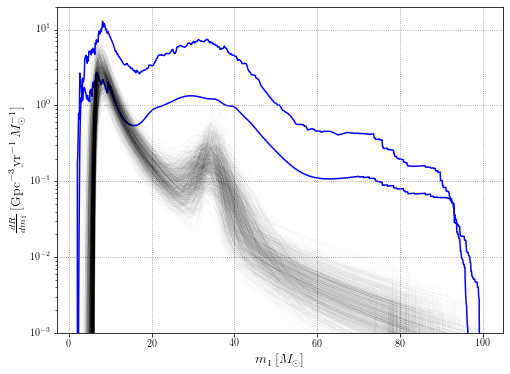

In [28]:
# Set up figure
fig,ax = plt.subplots(figsize=(8,6))

# Loop across gwpopulation results, plotting posteriors on dR/dm1
m1_grid = np.linspace(2,100,1000)
for i in range(1000):
    y = f['lines']['mass_1'][i,:]
    ax.plot(np.linspace(2,100,1000),y,color='black',alpha=0.1,lw=0.1)

# Now compute mass posteriors as inferred by our stochastic-oriented analysis
p_m1s = np.zeros((processed_samps.shape[0],m1_grid.size))
for i,samp in enumerate(processed_samps):
    
    R0 = samp[2]
    mMin = samp[3]
    mMax = samp[4]
    lmbda = samp[5]
    mu_peak = samp[6]
    sig_peak = samp[7]
    frac_peak = samp[8]
    
    p_m1 = R0*plPeakDistribution(m1_grid,lmbda,mu_peak,sig_peak,mMin,mMax,frac_peak)
    p_m1[m1_grid<mMin] = 0
    p_m1[m1_grid>mMax] = 0
    p_m1s[i] = p_m1
    
# Plot quantiles
ax.plot(m1_grid,np.mean(p_m1s,axis=0),color='blue',zorder=-1)
ax.plot(m1_grid,np.quantile(p_m1s,0.05,axis=0),color='blue',zorder=-1)
ax.plot(m1_grid,np.quantile(p_m1s,0.95,axis=0),color='blue',zorder=-1)

ax.set_yscale('log')
ax.set_ylim(1e-3,20)
ax.set_xlabel(r'$m_1\,[M_\odot]$',fontsize=14)
ax.set_ylabel(r'$\frac{dR}{dm_1}\,[\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,M_\odot^{-1}]$',fontsize=14)
ax.grid(True,which='major',color='grey',ls=':')

plt.savefig('rz_stochasticOnly_gwpop_comparison.png',dpi=150)
plt.show()

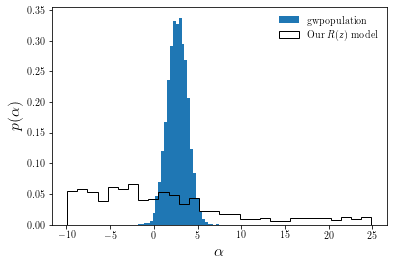

In [29]:
gwpop_file = "/home/thomas.callister/CBC/o3b-population-data/analyses/PowerLawPeak/o1o2o3_mass_c_iid_mag_iid_tilt_powerlaw_redshift_result.json"
with open(gwpop_file,'r') as jf:
    gwpop_results = json.load(jf)

fig,ax = plt.subplots()
ax.hist(np.array(gwpop_results['posterior']['content']['lamb']),density=True,bins=30,
        label="gwpopulation")
ax.hist(processed_samps[:,-3],density=True,bins=30,
        histtype='step',color='black',label="Our $R(z)$ model")
ax.legend(loc='upper right',frameon=False)
ax.set_xlabel(r'$\alpha$',fontsize=16)
ax.set_ylabel(r'$p(\alpha)$',fontsize=16)
plt.savefig('rz_stochasticOnly_alphaComparison.png',dpi=150)
plt.show()

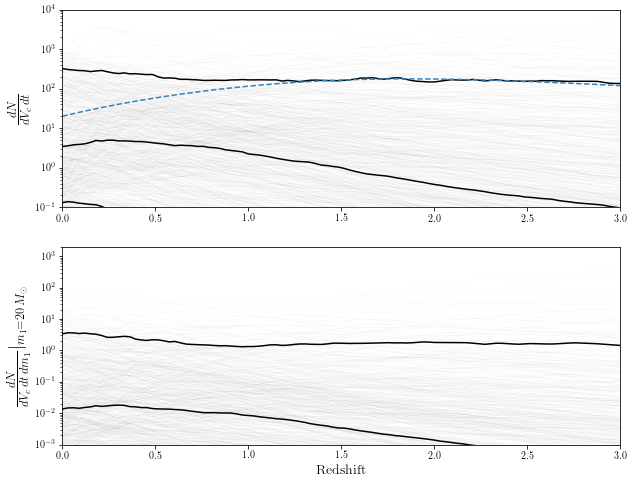

In [30]:
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

# Grid of redshifts
z_grid = np.linspace(0,3,100)

# Track two different rate densities --
# The rate density dR/dm1(z) evaluated *at* 20Msun, and the overall rate density
# R(z), integrated over masses
r_zs_m1 = np.zeros((processed_samps.shape[0],z_grid.size))
r_zs = np.zeros((processed_samps.shape[0],z_grid.size))

# Loop across samples
for i,samp in enumerate(processed_samps):
    
    R0 = samp[2]
    mMin = samp[3]
    mMax = samp[4]
    lmbda = samp[5]
    mu_peak = samp[6]
    sig_peak = samp[7]
    frac_peak = samp[8]
    alpha = samp[10]
    beta = samp[11]
    zp = samp[12]
    
    # Evaluate mass distribution at 20 Msun
    p_m1 = plPeakDistribution(np.array([20.]),lmbda,mu_peak,sig_peak,mMin,mMax,frac_peak)
    
    # Construct R(z) and normalize to local merger rate
    r_z = (1.+z_grid)**alpha/(1.+((1.+z_grid)/(1.+zp))**(alpha+beta))
    r_z /= r_z[0]
    r_z *= R0
    
    # Store
    r_zs[i,:] = r_z
    r_zs_m1[i,:] = r_z*p_m1
    
    ax1.plot(z_grid,r_z,color='black',lw=0.1,alpha=0.1)
    ax2.plot(z_grid,r_z*p_m1,color='black',lw=0.1,alpha=0.1)

ax1.plot(z_grid,np.quantile(r_zs,0.05,axis=0),color='black') 
ax1.plot(z_grid,np.quantile(r_zs,0.95,axis=0),color='black') 
ax1.plot(z_grid,np.median(r_zs,axis=0),color='black')

ax2.plot(z_grid,np.quantile(r_zs_m1,0.05,axis=0),color='black') 
ax2.plot(z_grid,np.quantile(r_zs_m1,0.95,axis=0),color='black') 
ax2.plot(z_grid,np.median(r_zs_m1,axis=0),color='black')

MD_SFR = np.power(1.+z_grid,2.7)/(1.+np.power((1.+z_grid)/2.9,5.6))
MD_SFR *= 20/MD_SFR[0]
ax1.plot(z_grid,MD_SFR,color='#3182bd',ls='--')

ax1.set_yscale('log')
ax1.set_xlim(0,3)
ax1.set_ylim(1e-1,1e4)
ax1.set_ylabel(r'$\frac{dN}{dV_c\,dt}$',fontsize=18)

ax2.set_yscale('log')
ax2.set_xlim(0,3)
ax2.set_ylim(1e-3,2e3)
ax2.set_xlabel('Redshift',fontsize=14)
ax2.set_ylabel(r'$\frac{dN}{dV_c\,dt\,dm_1}|_{m_1=20\,M_\odot}$',fontsize=18)

plt.savefig('rz_stochasticOnly_rateEvolution.png',dpi=150)
plt.show()